# Part 3
## Question 1

In [163]:
import numpy as np
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
import time


In [164]:
def asian_geom_option_price_analytical(S0, K, r, sigma, T, N):
    # Analytical solution for the price of an Asian geometric average option
    sigma_tilde = sigma * np.sqrt((2 * N + 1)/(6 * (N + 1)))
    r_tilde = (r - 0.5 * sigma**2 + sigma_tilde**2) / 2

    d1 = (np.log(S0/K) + (r_tilde + 0.5 * sigma_tilde**2) * T) / (sigma_tilde * np.sqrt(T))
    d2 = (np.log(S0/K) + (r_tilde - 0.5 * sigma_tilde**2) * T) / (sigma_tilde * np.sqrt(T))
    C_analytical = np.exp(-r * T) * (S0 * np.exp(r_tilde * T) * norm.cdf(d1) - K * norm.cdf(d2))
    return C_analytical

In [165]:
def asian_geom_option_price_simul(S0, K, r, sigma, T, N, M, seed=None):
    # Simulate the price of an Asian geometric average option
    dt = T / N

    # Monte-Carlo simulations
    np.random.seed(seed)
    A_N = np.zeros(M)
    for i in range(M):
        S = np.zeros(N+1)
        S[0] = S0
        for j in range(1, N+1):
            S[j] = S[j-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.standard_normal())
    
        A_N[i] = np.prod(S)**(1/(N + 1))
    return np.exp(-r * T) * np.maximum(A_N - K, 0).mean(), np.maximum(A_N - K, 0)

The price of the Asian option based on geometric averages using the analytical expression is 5.534135324825505
The price of the Asian option based on geometric averages using Monte-Carlo simulations is 5.570881653494115


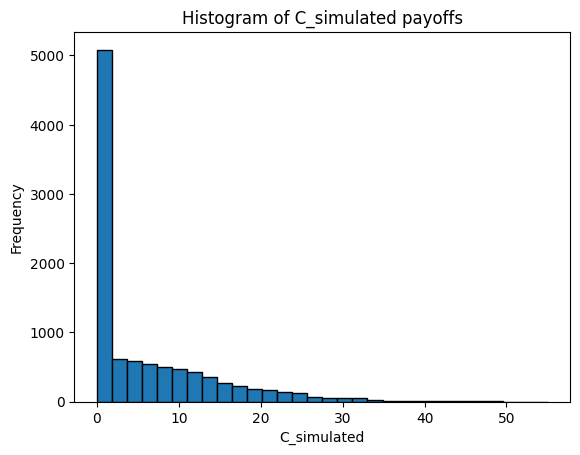

In [166]:
# Settling the parameters
S0 = 100
K = 100
r = 0.05
sigma = 0.2
T = 1
N = 100 # Number of time steps (higher than 100 gives overflow error)

# Analytical:
C_analytical = asian_geom_option_price_analytical(S0, K, r, sigma, T, N)
print('The price of the Asian option based on geometric averages using the analytical expression is', C_analytical)

# Simulated:
M = 10000 # Number of simulations
C_simulated, C = asian_geom_option_price_simul(S0, K, r, sigma, T, N, M)
print('The price of the Asian option based on geometric averages using Monte-Carlo simulations is', C_simulated)

# Plot C_simulated histogram
plt.hist(C, bins=30, edgecolor='k')
plt.title('Histogram of C_simulated payoffs')
plt.xlabel('C_simulated')
plt.ylabel('Frequency')
plt.show()



## Question 2
- Geometric average is positively correlated to the arithmetic average, so can be used as control variate.
- $\lambda$ is unknown so we use sample variance and covariance for that.

## Question 3

In [207]:
def asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, seed=None, control_variate=False):
    # Simulate the price of an Asian arithmetic average option
    dt = T / N

    # Monte-Carlo simulations
    np.random.seed(seed)
    A_N_arith = np.zeros(M)
    A_N_geom = np.zeros(M)

    for i in range(M):
        S = np.zeros(N+1)
        S[0] = S0
        for j in range(1, N+1):
            S[j] = S[j-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.standard_normal())
        
        A_N_arith[i] = S.mean()

        if control_variate:
            # Subsets of size 50 (this way we avoid overflow errors and zeroes):
            subsets = [S[i:i+50] for i in range(0, len(S), 50)]
            A_N_geom[i] = np.prod([np.prod(S)**(1/(N + 1)) for S in subsets])

    payoff_arith = np.maximum(A_N_arith - K, 0)

    if control_variate:
        payoff_geom = np.maximum(A_N_geom - K, 0)

        sample_EV = payoff_geom.mean()
        sample_var = np.var(payoff_geom)
        sample_covar = np.cov(payoff_arith, payoff_geom)[0, 1]
        sample_lambda = sample_covar / sample_var

        payoff_controlled = (payoff_arith - sample_lambda * (payoff_geom - sample_EV))

        return np.exp(-r * T) * payoff_controlled.mean(), payoff_controlled

    return np.exp(-r * T) * payoff_arith.mean(), payoff_arith

In [208]:
# Settling the parameters
S0 = 100
K = 150
r = 0.05
sigma = 0.2
T = 1
N = 100

# Simulated:
M = 100 # Number of simulations
start = time.time()
C_control_variate, payoffs_control = asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, control_variate=True)
control_time = time.time() - start
C_original, payoffs_original = asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, control_variate=False)
original_time = time.time() - start - control_time
print(f"Price Estimated using control variate: {C_control_variate} in {control_time} seconds. Payoffs had variance {np.var(payoffs_control)}")
print(f"Price Estimated without control variate: {C_original} in {original_time} seconds. Payoffs had variance {np.var(payoffs_original)}")

Price Estimated using control variate: nan in 0.023242712020874023 seconds. Payoffs had variance nan
Price Estimated without control variate: 0.0 in 0.022418975830078125 seconds. Payoffs had variance 0.0


C:\Users\Admin\AppData\Local\Temp\ipykernel_27996\2286081855.py:31: RuntimeWarning: invalid value encountered in scalar divide
  sample_lambda = sample_covar / sample_var


Price Estimated using control variate: 5.705141879259184 in 2.12693190574646 seconds. Payoffs had variance 0.05278697542305723
Price Estimated without control variate: 5.767621250329129 in 2.0298986434936523 seconds. Payoffs had variance 69.69995130207504
The price of the Asian option based on arithmetic averages using Monte-Carlo simulations with control variate is 5.705141879259184
The price of the Asian option based on arithmetic averages using Monte-Carlo simulations without control variate is 5.767621250329129


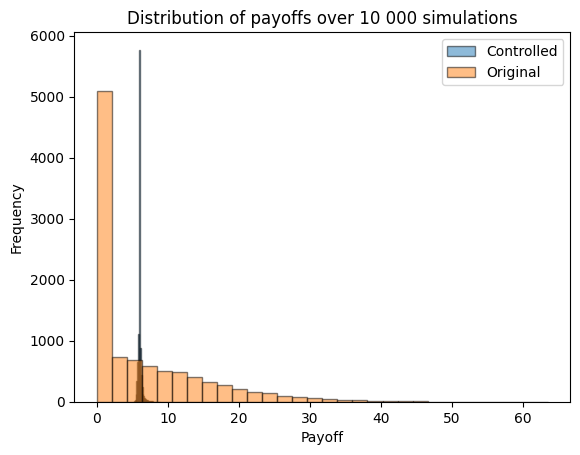

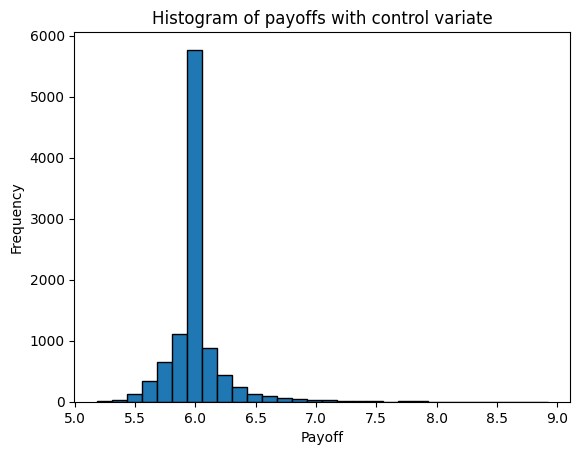

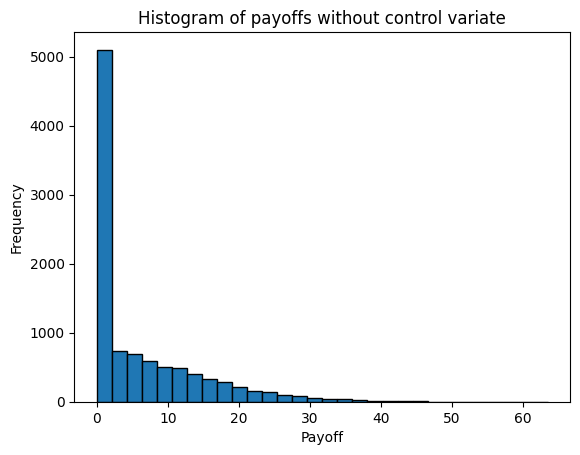

In [168]:
# Settling the parameters
S0 = 100
K = 100
r = 0.05
sigma = 0.2
T = 1
N = 100

# Simulated:
M = 10000 # Number of simulations
start = time.time()
C_control_variate, payoffs_control = asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, control_variate=True)
control_time = time.time() - start
C_original, payoffs_original = asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, control_variate=False)
original_time = time.time() - start - control_time
print(f"Price Estimated using control variate: {C_control_variate} in {control_time} seconds. Payoffs had variance {np.var(payoffs_control)}")
print(f"Price Estimated without control variate: {C_original} in {original_time} seconds. Payoffs had variance {np.var(payoffs_original)}")
print('The price of the Asian option based on arithmetic averages using Monte-Carlo simulations with control variate is', C_control_variate)
print('The price of the Asian option based on arithmetic averages using Monte-Carlo simulations without control variate is', C_original)


# Plot them together
plt.hist(payoffs_control, bins=30, edgecolor='k', alpha=0.5, label='Controlled')
plt.hist(payoffs_original, bins=30, edgecolor='k', alpha=0.5, label='Original')
plt.title('Distribution of payoffs over 10 000 simulations')
plt.xlabel('Payoff')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot them seperately
plt.hist(payoffs_control, bins=30, edgecolor='k')
plt.title('Histogram of payoffs with control variate')
plt.xlabel('Payoff')
plt.ylabel('Frequency')
plt.show()

plt.hist(payoffs_original, bins=30, edgecolor='k')
plt.title('Histogram of payoffs without control variate')
plt.xlabel('Payoff')
plt.ylabel('Frequency')
plt.show()



Varying the number of paths?? is M?

Finding the convergence of the option price for increased simulations:   0%|          | 0/10 [00:00<?, ?it/s]

Finding the convergence of the option price for increased simulations: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


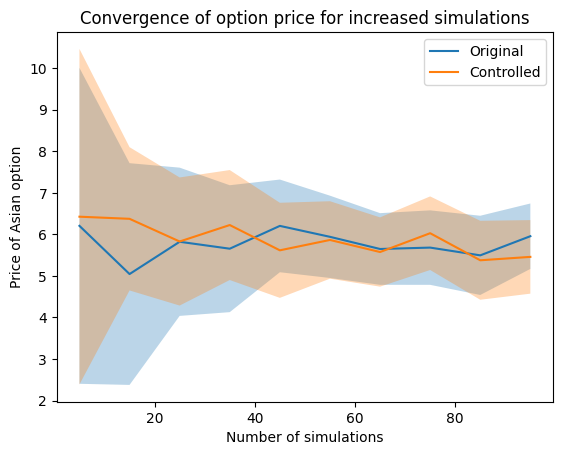

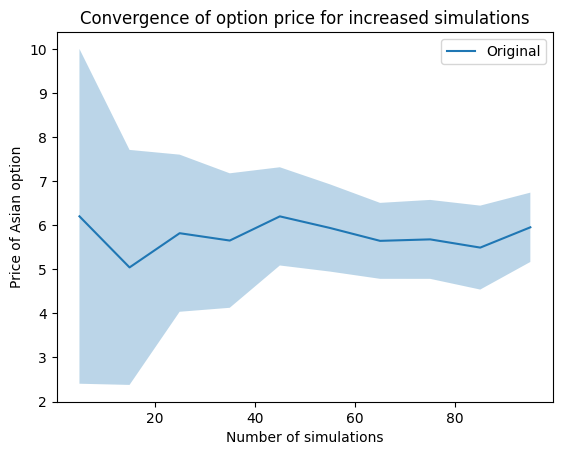

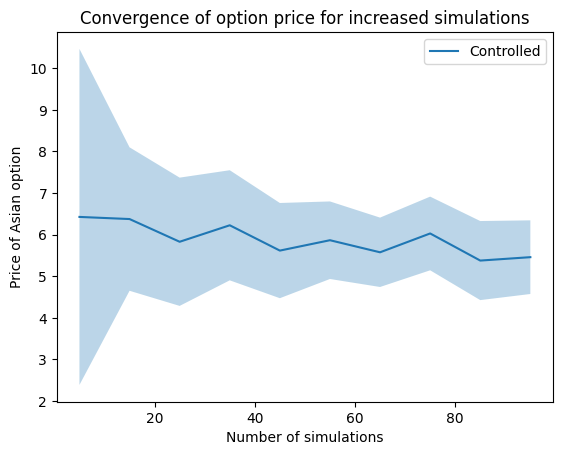

In [169]:
# Settling the parameters
S0 = 100
K = 100
r = 0.05
sigma = 0.2
T = 1
N = 100
#M = 100 # Number of simulations


path_range = np.arange(5,100,10) # set 1000 instead of 50 for the resut in report
pi_values_controlled = []    # To store the results
pi_values_original = []
pi_vars_controlled = []    # To store the variance
pi_vars_original = []

repetitions = 25 # repetitions to find the variance for one M

for M in tqdm(path_range, desc='Finding the convergence of the option price for increased simulations'):
    values_original = []
    values_controlled = []
    for reps in range(repetitions):
        option_control_variate,_ = asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, control_variate=True)
        option_original,_ = asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, control_variate=False)
        values_controlled.append(option_control_variate)
        values_original.append(option_original)
    print(values_controlled)
    print(values_original)
    pi_values_controlled.append(np.mean(values_controlled))
    pi_values_original.append(np.mean(values_original))
    pi_vars_controlled.append(np.var(values_controlled))
    pi_vars_original.append(np.var(values_original))

# Plot the results, with variance as fill_between
plt.plot(path_range, pi_values_original, label='Original')
plt.fill_between(path_range, np.array(pi_values_original) - np.sqrt(pi_vars_original), np.array(pi_values_original) + np.sqrt(pi_vars_original), alpha=0.3)
plt.plot(path_range, pi_values_controlled, label='Controlled')
plt.fill_between(path_range, np.array(pi_values_controlled) - np.sqrt(pi_vars_controlled), np.array(pi_values_controlled) + np.sqrt(pi_vars_controlled), alpha=0.3)
plt.xlabel('Number of simulations')
plt.ylabel('Price of Asian option')
plt.title("Convergence of option price for increased simulations")
plt.legend()
plt.show()

# And now both seperately
plt.plot(path_range, pi_values_original, label='Original')
plt.fill_between(path_range, np.array(pi_values_original) - np.sqrt(pi_vars_original), np.array(pi_values_original) + np.sqrt(pi_vars_original), alpha=0.3)
plt.xlabel('Number of simulations')
plt.ylabel('Price of Asian option')
plt.title("Convergence of option price for increased simulations")
plt.legend()
plt.show()

plt.plot(path_range, pi_values_controlled, label='Controlled')
plt.fill_between(path_range, np.array(pi_values_controlled) - np.sqrt(pi_vars_controlled), np.array(pi_values_controlled) + np.sqrt(pi_vars_controlled), alpha=0.3)
plt.xlabel('Number of simulations')
plt.ylabel('Price of Asian option')
plt.title("Convergence of option price for increased simulations")
plt.legend()
plt.show()

# plt.plot(path_range, pi_values_original, label='Original')
# plt.plot(path_range, pi_values_controlled, label='Controlled')
# plt.xlabel('Number of simulations')
# plt.ylabel('Price of Asian option')
# plt.title("Convergence of option price for increased simulations")
# plt.legend()
# plt.show()


Varing the strike price K

Finding the strike price's effect on the option price:  89%|████████▉ | 8/9 [00:08<00:01,  1.06s/it]C:\Users\Admin\AppData\Local\Temp\ipykernel_27996\2286081855.py:31: RuntimeWarning: invalid value encountered in scalar divide
  sample_lambda = sample_covar / sample_var
Finding the strike price's effect on the option price: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


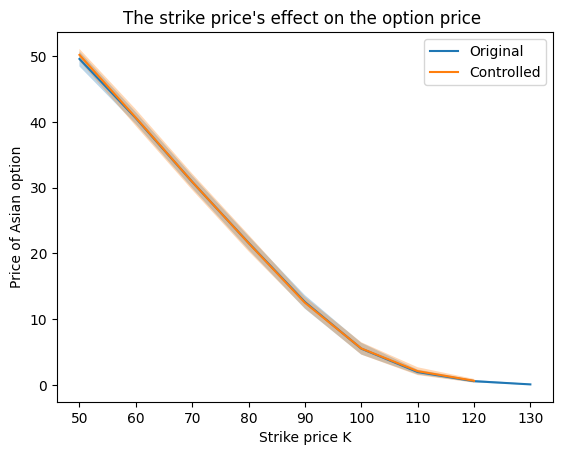

In [214]:
# Settling the parameters
S0 = 100
r = 0.05
sigma = 0.2
T = 1
N = 100
M = 100 # Number of simulations


strike_price_range = np.arange(50,150,10) # set 500 instead of 50 for the resut in report
pi_values_controlled = []    # To store the results
pi_values_original = []
pi_vars_controlled = []    # To store the variance
pi_vars_original = []

repetitions = 25 # repetitions to find the variance for one strike price

for K in tqdm(strike_price_range, desc="Finding the strike price's effect on the option price"):
    values_original = []
    values_controlled = []
    for reps in range(repetitions):
        option_control_variate,_ = asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, control_variate=True)
        option_original,_ = asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, control_variate=False)
        values_controlled.append(option_control_variate)
        values_original.append(option_original)
    
    pi_values_controlled.append(np.mean(values_controlled))
    pi_values_original.append(np.mean(values_original))
    pi_vars_controlled.append(np.var(values_controlled))
    pi_vars_original.append(np.var(values_original))

# Plot the results, with variance as fill_between
plt.plot(strike_price_range, pi_values_original, label='Original')
plt.fill_between(strike_price_range, np.array(pi_values_original) - np.sqrt(pi_vars_original), np.array(pi_values_original) + np.sqrt(pi_vars_original), alpha=0.3)
plt.plot(strike_price_range, pi_values_controlled, label='Controlled')
plt.fill_between(strike_price_range, np.array(pi_values_controlled) - np.sqrt(pi_vars_controlled), np.array(pi_values_controlled) + np.sqrt(pi_vars_controlled), alpha=0.3)
plt.xlabel('Strike price K')
plt.ylabel('Price of Asian option')
plt.title("The strike price's effect on the option price ")
plt.legend()
plt.show()

# plt.plot(strike_price_range, pi_values_original, label='Original')
# plt.plot(strike_price_range, pi_values_controlled, label='Controlled')
# plt.xlabel('Strike price K')
# plt.ylabel('Price of Asian option')
# plt.title("The strike price's effect on the option price ")
# plt.legend()
# plt.show()


Varing the number of time points N?

Finding the convergence of the option price for increased timepoints:   0%|          | 0/29 [00:00<?, ?it/s]

Finding the convergence of the option price for increased timepoints: 100%|██████████| 29/29 [00:46<00:00,  1.61s/it]


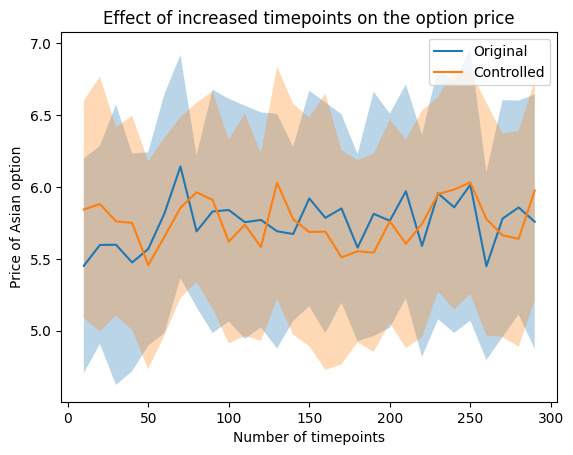

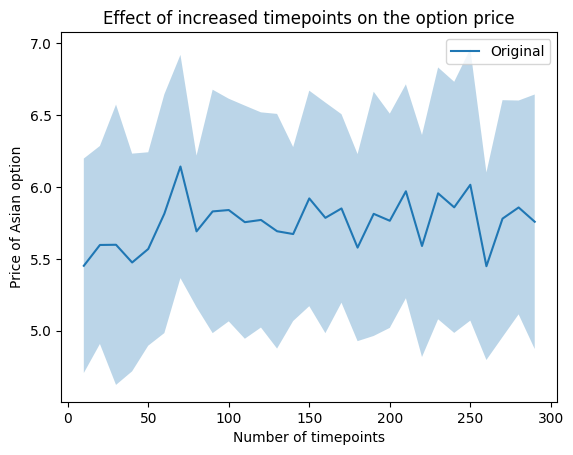

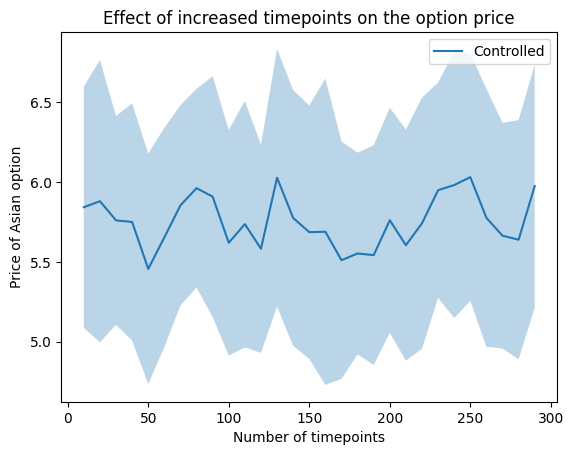

In [171]:
# Settling the parameters
S0 = 100
K = 100
r = 0.05
sigma = 0.2
T = 1
N = 100 # timepoints
#M = 100 # Number of simulations


timepoints_range = np.arange(10,300,10) # set 500 instead of 50 for the resut in report
pi_values_controlled = []    # To store the results
pi_values_original = []
pi_vars_controlled = []    # To store the variance
pi_vars_original = []

repetitions = 25 # repetitions to find the variance for one N

for N in tqdm(timepoints_range, desc='Finding the convergence of the option price for increased timepoints'):
    values_original = []
    values_controlled = []
    for reps in range(repetitions):
        option_control_variate,_ = asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, control_variate=True)
        option_original,_ = asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, control_variate=False)
        values_controlled.append(option_control_variate)
        values_original.append(option_original)
    
    pi_values_controlled.append(np.mean(values_controlled))
    pi_values_original.append(np.mean(values_original))
    pi_vars_controlled.append(np.var(values_controlled))
    pi_vars_original.append(np.var(values_original))

# Plot the results, with variance as fill_between
plt.plot(timepoints_range, pi_values_original, label='Original')
plt.fill_between(timepoints_range, np.array(pi_values_original) - np.sqrt(pi_vars_original), np.array(pi_values_original) + np.sqrt(pi_vars_original), alpha=0.3)
plt.plot(timepoints_range, pi_values_controlled, label='Controlled')
plt.fill_between(timepoints_range, np.array(pi_values_controlled) - np.sqrt(pi_vars_controlled), np.array(pi_values_controlled) + np.sqrt(pi_vars_controlled), alpha=0.3)
plt.xlabel('Number of timepoints')
plt.ylabel('Price of Asian option')
plt.title("Effect of increased timepoints on the option price")
plt.legend()
plt.show()

# And now both seperately
plt.plot(timepoints_range, pi_values_original, label='Original')
plt.fill_between(timepoints_range, np.array(pi_values_original) - np.sqrt(pi_vars_original), np.array(pi_values_original) + np.sqrt(pi_vars_original), alpha=0.3)
plt.xlabel('Number of timepoints')
plt.ylabel('Price of Asian option')
plt.title("Effect of increased timepoints on the option price")
plt.legend()
plt.show()

plt.plot(timepoints_range, pi_values_controlled, label='Controlled')
plt.fill_between(timepoints_range, np.array(pi_values_controlled) - np.sqrt(pi_vars_controlled), np.array(pi_values_controlled) + np.sqrt(pi_vars_controlled), alpha=0.3)
plt.xlabel('Number of timepoints')
plt.ylabel('Price of Asian option')
plt.title("Effect of increased timepoints on the option price")
plt.legend()
plt.show()

# plt.plot(timepoints_range, pi_values_original, label='Original')
# plt.plot(timepoints_range, pi_values_controlled, label='Controlled')
# plt.xlabel('Number of timepoints')
# plt.ylabel('Price of Asian option')
# plt.title("Effect of increased timepoints on the option price")
# plt.legend()
# plt.show()